In [1]:
#imports from Sanzid
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy
import statistics
from numpy import loadtxt
import matplotlib.pyplot as plt
import pandas
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statistics import stdev
import math
import h5py

import numpy as np
import time

from scipy.signal import butter,filtfilt
import sys
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph.
import pandas
import matplotlib.pyplot as plt

# from tsf.model import TransformerForecaster


# from tensorflow.keras.utils import np_utils
import itertools
###  Library for attention layers
import pandas as pd
import os
import numpy as np
#from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split

import statistics
import gc
import torch.nn.init as init

############################################################################################################################################################################
############################################################################################################################################################################

import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.utils.weight_norm as weight_norm
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
#from torchsummary import summary
from torch.nn.parameter import Parameter

#from torchsummary import summary



import torch.optim as optim
import gc

#from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
#imports for this notebook using sensor distillation utils
import sys #you need this to add path to utils folder
sys.path.append('../Sensor_distillation_utils') #now you can import from utils folder
from sensor_distillation import train_SD
from student_model import student
from teacher_model import teacher
from train import train_kinematics
from predictions import prediction_test

In [3]:
#loading in data from lightweight kinematics net
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os

In [4]:
# data loader will return [batch_size, sequence_length, input_dim] for 3 vector, acc and gyro as well as the target 
# from kinematics net notebook
class Sensor_Distillation_Dataset(Dataset):
    def __init__(self, data_acc, data_gyr, target, w, overlap=200):
        self.data_acc = data_acc
        self.data_gyr = data_gyr
        self.target = target
        self.w = w
        self.overlap = overlap

    def __len__(self):
        return (len(self.data_acc) - self.w) // (self.w - self.overlap) + 1

    def __getitem__(self, idx):
        start = idx * (self.w - self.overlap)
        end = start + self.w
        return (torch.tensor(self.data_acc[start:end]),
                torch.tensor(self.data_gyr[start:end]),
                torch.tensor(self.target[start:end]))  # Updated to return the entire target sequence

       pelvis_tilt  pelvis_list  pelvis_rotation  pelvis_tx  pelvis_ty  \
0       -12.783946    -6.860518        88.296799   0.021799   0.697469   
1       -12.787659    -6.836424        88.299534   0.021769   0.697361   
2       -12.791372    -6.812330        88.302268   0.021739   0.697254   
3       -12.795085    -6.788236        88.305002   0.021709   0.697147   
4       -12.798798    -6.764142        88.307736   0.021679   0.697039   
...            ...          ...              ...        ...        ...   
64576    -0.938869    18.009269        89.379651  -0.005740   0.682911   
64577    -0.938253    18.006441        89.375682  -0.005762   0.682864   
64578    -0.937637    18.003613        89.371714  -0.005785   0.682818   
64579    -0.937021    18.000786        89.367746  -0.005807   0.682772   
64580    -0.936405    17.997958        89.363777  -0.005830   0.682726   

       pelvis_tz  hip_flexion_r  hip_adduction_r  hip_rotation_r  \
0      -0.414633      81.400694        -7.4

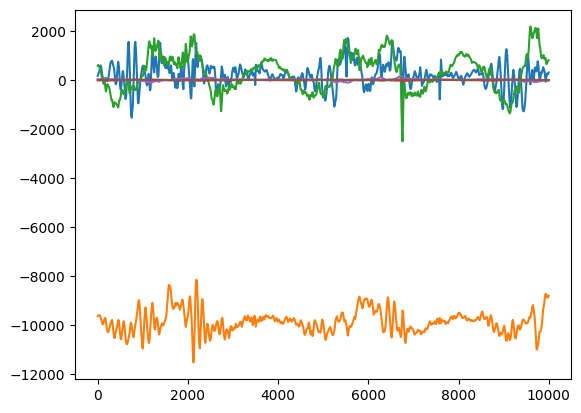

In [5]:


# Load and clean the combined CSV data
import sys #you need this to add path to utils folder
sys.path.append('../../datacollection') #now you can import from utils folder
from batch_process import combine_and_save_data

remake_combined = False
if remake_combined == True:   
    combine_and_save_data("../../datacollection/vicon/subject_1/processed", "../../datacollection/vicon/subject_1/sensors", "../../datacollection/vicon/subject_1/combined")

combined_csv = pd.read_csv("../../datacollection/vicon/subject_1/combined/P001_T001_armSwing_fast_combined.csv")

print(combined_csv)

# Plot ACCX8, ACCY8, ACCZ8, GYROX8, GYROY8, GYROZ8
plt.plot(combined_csv['ACCX8'][:10000])
plt.plot(combined_csv['ACCY8'][:10000])
plt.plot(combined_csv['ACCZ8'][:10000])
plt.plot(combined_csv['GYROX8'][:10000])
plt.plot(combined_csv['GYROY8'][:10000])
plt.plot(combined_csv['GYROZ8'][:10000])
plt.show()

# Get two 3-channel arrays for ACC and GYRO for sensor 2
data_acc = combined_csv[['ACCX2', 'ACCY2', 'ACCZ2']].values
data_gyr = combined_csv[['GYROX2', 'GYROY2', 'GYROZ2']].values

# Normalize the data
scaler_acc = StandardScaler()
scaler_gyr = StandardScaler()
scaler_joints = StandardScaler()

data_acc = scaler_acc.fit_transform(data_acc)
data_gyr = scaler_gyr.fit_transform(data_gyr)
data_joints = combined_csv[['elbow_flex_r']].values
data_joints = scaler_joints.fit_transform(data_joints)

# Create dataset instances with overlapping windows
dataset = Sensor_Distillation_Dataset(data_acc, data_gyr, data_joints, w=1000, overlap=500)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

torch.Size([64, 1000, 3])
torch.Size([64, 1000, 3])
torch.Size([64, 1000, 1])


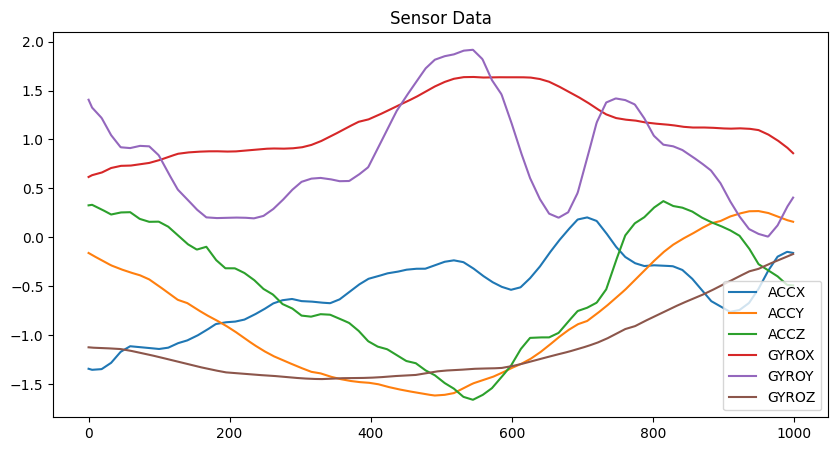

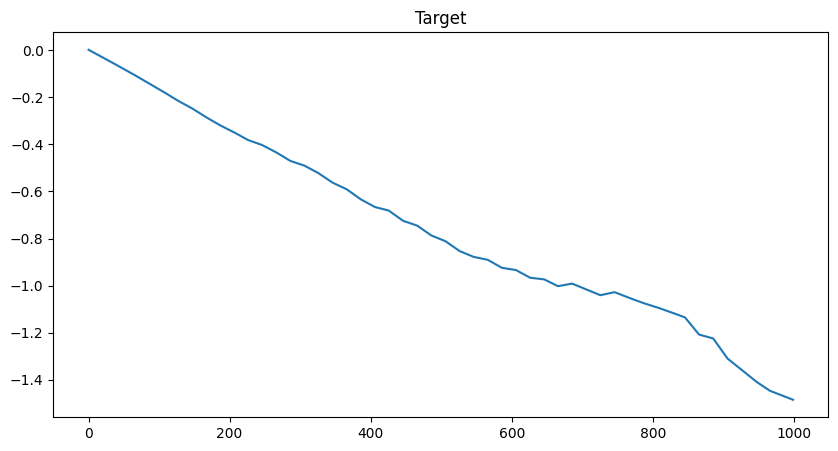

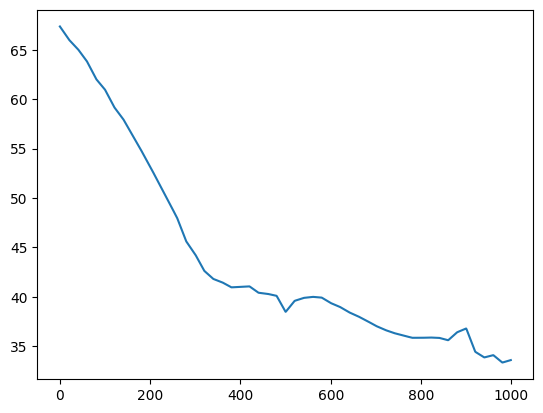

In [6]:
#get first batch
data_acc, data_gyr, data_targets = next(iter(train_loader))

#print the shapes of the tensors
print(data_acc.shape)
print(data_gyr.shape)
print(data_targets.shape)


#plot the first 1000 samples of the first batch
plt.figure(figsize=(10, 5))
plt.plot(data_acc[0, :, 0], label='ACCX')
plt.plot(data_acc[0, :, 1], label='ACCY')
plt.plot(data_acc[0, :, 2], label='ACCZ')
plt.plot(data_gyr[0, :, 0], label='GYROX')
plt.plot(data_gyr[0, :, 1], label='GYROY')
plt.plot(data_gyr[0, :, 2], label='GYROZ')
plt.legend()
plt.title('Sensor Data')
plt.show()

#plot the first 1000 samples of the first batch
plt.figure(figsize=(10, 5))
plt.plot(data_targets[0,:1000])
plt.title('Target')
plt.show()

plt.plot(combined_csv[['elbow_flex_r']].values[:1000])
plt.show()

In [7]:
#load in test data
remake_combined_test = False
if remake_combined_test == True:   
    combine_and_save_data("../../datacollection/vicon/subject_2/processed", "../../datacollection/vicon/subject_2/sensors", "../../datacollection/vicon/subject_2/combined")

combined_csv_test = pd.read_csv("../../datacollection/vicon/subject_2/combined/P002_T001_armSwing_fast_combined.csv")

combined_csv_test

,pelvis_tilt,pelvis_list,pelvis_rotation,pelvis_tx,pelvis_ty,pelvis_tz,hip_flexion_r,hip_adduction_r,hip_rotation_r,knee_angle_r,...,ACCZ6,GYROX6,GYROY6,GYROZ6,ACCX10,ACCY10,ACCZ10,GYROX10,GYROY10,GYROZ10
0,11.890805,37.582795,75.420023,-0.017601,0.834376,-0.399835,15.830071,-4.472135,-3.414486,60.197529,...,-415.362,-42.3137,9.58951,-30.1854,-748.346,-8417.35,809.918,-2.356060,16.2287,-9.83925
1,11.906949,37.616197,75.412252,-0.017622,0.834368,-0.399764,15.793211,-4.470451,-3.421794,60.196726,...,-410.680,-42.5139,8.15014,-30.8075,-757.381,-8437.18,788.507,-2.311620,16.6700,-9.97374
2,11.923093,37.649599,75.404482,-0.017643,0.834360,-0.399693,15.756350,-4.468767,-3.429102,60.195923,...,-405.998,-42.7141,6.71078,-31.4296,-766.417,-8457.00,767.095,-2.267180,17.1113,-10.10820
3,11.939237,37.683001,75.396711,-0.017664,0.834352,-0.399623,15.719490,-4.467083,-3.436410,60.195120,...,-401.316,-42.9143,5.27141,-32.0517,-775.452,-8476.82,745.683,-2.222750,17.5526,-10.24270
4,11.955381,37.716403,75.388941,-0.017685,0.834344,-0.399552,15.682629,-4.465399,-3.443718,60.194317,...,-396.635,-43.1145,3.83205,-32.6737,-784.487,-8496.64,724.272,-2.178310,17.9939,-10.37720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61536,2.180815,51.496776,79.252617,-0.010030,0.835499,-0.389717,4.414835,-14.910510,1.270578,62.912125,...,2357.060,-145.2670,-282.28800,-55.5417,-484.523,-10163.90,3237.850,1.226590,-57.8488,-16.99000
61537,2.228752,51.545374,79.256800,-0.010131,0.835473,-0.389619,4.343735,-14.893746,1.221812,62.904400,...,2354.970,-145.1080,-284.00900,-55.0359,-468.937,-10152.40,3272.500,0.740600,-59.4474,-16.92910
61538,2.276689,51.593973,79.260982,-0.010232,0.835447,-0.389522,4.272636,-14.876983,1.173047,62.896675,...,2352.890,-144.9480,-285.73000,-54.5302,-453.351,-10140.90,3307.150,0.254611,-61.0461,-16.86830
61539,2.324627,51.642571,79.265164,-0.010333,0.835421,-0.389425,4.201536,-14.860219,1.124282,62.888949,...,2350.810,-144.7890,-287.45200,-54.0245,-437.765,-10129.40,3341.800,-0.231377,-62.6447,-16.80750


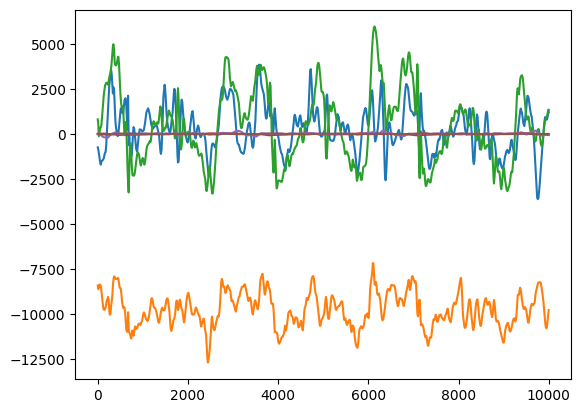

In [8]:
# Plot ACCX8, ACCY8, ACCZ8, GYROX8, GYROY8, GYROZ8
plt.plot(combined_csv_test['ACCX10'][:10000])
plt.plot(combined_csv_test['ACCY10'][:10000])
plt.plot(combined_csv_test['ACCZ10'][:10000])
plt.plot(combined_csv_test['GYROX10'][:10000])
plt.plot(combined_csv_test['GYROY10'][:10000])
plt.plot(combined_csv_test['GYROZ10'][:10000])
plt.show()

# Get two 3-channel arrays for ACC and GYRO for sensor 2
data_acc_test = combined_csv_test[['ACCX2', 'ACCY2', 'ACCZ2']].values
data_gyr_test = combined_csv_test[['GYROX2', 'GYROY2', 'GYROZ2']].values

# Normalize the data
scaler_acc = StandardScaler()
scaler_gyr = StandardScaler()
scaler_joints = StandardScaler()

data_acc_test = scaler_acc.fit_transform(data_acc_test)
data_gyr_test = scaler_gyr.fit_transform(data_gyr_test)
data_targets_test = combined_csv_test[['elbow_flex_r']].values
data_targets_test = scaler_joints.fit_transform(data_targets_test)


# Create dataset instances with overlapping windows for test data
test_dataset = Sensor_Distillation_Dataset(data_acc_test, data_gyr_test, data_targets_test, w=1000, overlap=500)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:

#define device
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
#run model initialization and train model, teacher model
alpha=0.50
num_epoch=30
lr = 0.001
input_size = 3
output_size = 3
model = teacher(3,3, 100)

gait_Net_teacher = train_kinematics(train_loader, lr,num_epoch,model, "../../datacollection/subject_1/test", input_size, output_size)

NameError: name 'k_1' is not defined